In [1]:
import sys
import os
from scipy.io import wavfile
import numpy as np
import theano
from theano import tensor as T
import lasagne
from lasagne.layers import *
from lasagne.init import *
from lasagne.nonlinearities import *
from lasagne.objectives import *
from lasagne.updates import *
import cPickle as pickle
import matplotlib.pyplot as plt
%matplotlib inline

//anaconda/lib/python2.7/site-packages/Theano-0.8.0.dev0-py2.7.egg/theano/tensor/signal/downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


In [2]:
%load_ext rpy2.ipython

In [4]:
os.environ["DATA_DIR"] = "/Volumes/CB_RESEARCH/vocal_synthesis"

In [5]:
data_folder = os.environ["DATA_DIR"]
with open(data_folder + os.path.sep + "x0.25_10_all_use_mean.pkl") as f:
    dat = pickle.load(f)
X_train, X_valid, X_test = dat[0]
X_train.shape, X_valid.shape, X_test.shape

((871, 40, 4000), (108, 40, 4000), (108, 40, 4000))

In [9]:
args = dict()
args["seed"] = 0
args["batch_size"] = 16
args["learning_rate"] = 0.01
args["momentum"] = 0.9
args["num_epochs"] = 2000
args["X_train"] = X_train
args["X_valid"] = X_valid
args["X_test"] = X_test
args["update_method"] = rmsprop

args["config"] = "../configurations/19feb_testing_d_minimalist2.py"

In [22]:
sys.path.append("..")
reload(exp)
import rnn_experiment as exp
symbols = exp.prepare(args)
out_fn = symbols["out_fn"]
l_out = symbols["l_out"]
with open(data_folder + os.path.sep + "expensive_models" + os.path.sep + \
          "x0.25_10_all_use_mean/16mar_minimalist2_use_mean.model") as f:
    model = pickle.load(f)
set_all_param_values(l_out, model)

loading config: ../configurations/19feb_testing_d_minimalist2.py
Number of params in model: 2206700


In [27]:
generated_seq = X_train[0:1,0:40].flatten().tolist()
generated_seq_array = []
# x1, x2, ..., x40
for i in range(0, 40):
    generated_seq_array.append(X_train[0:1, i, :][0])
ctr = 0
for x in range(0, 10):
    this_input = np.asarray(generated_seq_array[ctr::])
    #this_input = np.asarray(generated_seq_array)
    this_input = this_input.reshape( (1, this_input.shape[0], this_input.shape[1]))
    print this_input.shape
    
    #print this_input.shape
    #assert this_input.shape == (1, 40, 4000)
    
    # (1, 40, 4000) -> (40, 4000) -> get last elem
    # predict x2, x3, ..., x41
    # then append x41 to generated_seq_array
    # now next time, feed [x2, x3, ..., x41] to out_fn to get
    # [x3, x4, ... x42]
    this_out = out_fn(this_input)[0][-1]
    assert this_out.shape == (4000,)
    #print this_out.shape
    
    generated_seq_array.append(this_out)
    
    ctr += 1

(1, 40, 4000)
(1, 40, 4000)
(1, 40, 4000)
(1, 40, 4000)
(1, 40, 4000)
(1, 40, 4000)
(1, 40, 4000)
(1, 40, 4000)
(1, 40, 4000)
(1, 40, 4000)


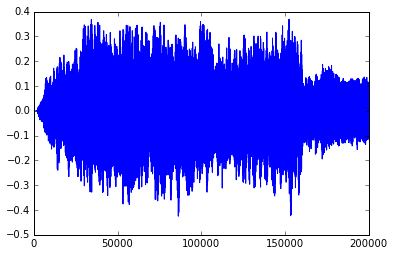

In [35]:
generated_seq = np.asarray(generated_seq_array).flatten()
plt.plot(generated_seq)

In [31]:
fs, data = wavfile.read(data_folder + os.path.sep + "data.wav")
print data.dtype
data = np.asarray(data, dtype="float32")
min_, max_, mean_ = np.min(data), np.max(data), np.mean(data)

int16


In [121]:
tmp = np.asarray(generated_seq)
tmp = (tmp * (max_ - min_)) + mean_
tmp = np.asarray(tmp, dtype="int16")

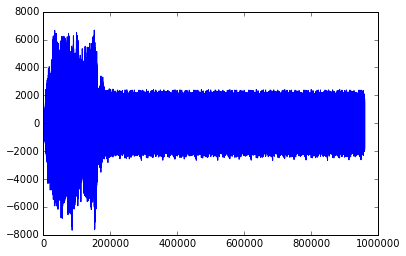

In [122]:
plt.plot(tmp)

In [123]:
out_file = "/tmp/t6000.wav"
#os.remove(out_file)
wavfile.write(filename=out_file, rate=fs, data=tmp)

----

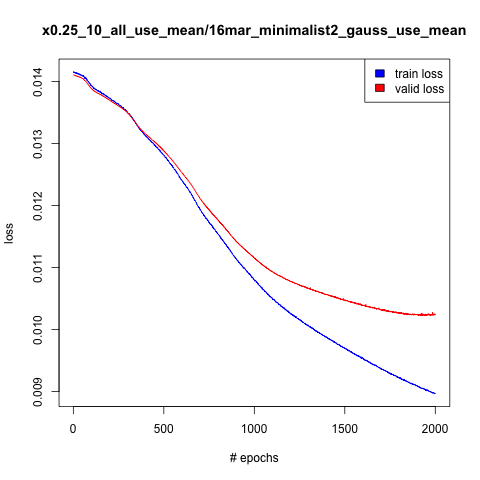

In [54]:
%%R
df = read.csv("../models/x0.25_10_all_use_mean/16mar_minimalist2_use_mean.txt")

plot(df$train_loss, type="l", xlab="# epochs", ylab="loss", col="blue", main="x0.25_10_all_use_mean/16mar_minimalist2_gauss_use_mean",
    ylim=c(  min( min(df$train_loss), min(df$valid_loss) ) , max( max(df$train_loss), max(df$valid_loss) )  ))
lines(df$valid_loss, type="l", col="red")
legend("topright", legend=c("train loss", "valid loss"), fill=c("blue", "red"))